In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt

import os 
import imageio
import scipy.io as spio
import cv2
from numpy import sqrt, pi, exp, transpose, matmul
from numpy.linalg import det, inv
from scipy.stats import norm 
from scipy.stats import multivariate_normal
import time
import sys

%matplotlib inline
plt.style.use('default')

Question A & Question B

In [63]:
# training
# load the original picture 
files_ori = glob.glob("apples/*.jpg")
ColorImgs = []
for myFile in files_ori:
    im = plt.imread(myFile)
    ColorImgs.append(im)

# load the mask
files_mask = glob.glob("apples/*.png")
MaskImgs = []
for myFile in files_mask:
    im = plt.imread(myFile)
    gray_image = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    MaskImgs.append(gray_image)

nIter = 70

# MixGaussian Code from practical C
def getMixGaussLogLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    
    # initialize log likelihoods                                                                       
    logLike = 0;                                                                                       
                                                                                                       
    # run through each data item                                                                       
    for cData in range(nData):                                                                         
        thisData = data[:, cData]                                                                      
        # TO DO - calculate likelihood of this data point under mixture of                         
        # Gaussians model. Replace this                                                                
        like = 0
        for k in range(mixGaussEst['k']):
            # Multivariate normal distribution PDF
            cov_k = mixGaussEst['cov'][:,:,k]
            mean_k = mixGaussEst['mean'][:,k]
            weight_k = mixGaussEst['weight'][k]
            centered_data_k = thisData - mean_k
            
            # Calculate likelihood for the k-th component
            like_k = weight_k * (1 / np.sqrt(((2 * np.pi) ** mixGaussEst['d']) * np.linalg.det(cov_k))) * \
                     np.exp(-0.5 * np.dot(np.dot((centered_data_k).T, np.linalg.inv(cov_k)), (centered_data_k)))
            like_k = max(like_k, 1e-10)

            # Accumulate likelihood over all components
            like += like_k
        # add to total log like                                                                        
        logLike = logLike + np.log(like)                                                               
                                                                                                       
    return  logLike.item()                                                                       
                                                                                                       
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape


    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    # for cGauss in range(k):
    #     mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)     
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims) + np.eye(nDims) * 0.001

    # calculate current likelihood
    # TO DO - fill in this routine
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))


    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================

        for cData in range(nData):
            # TO DO (g) : fill in column of 'hidden' - calculate posterior probability that
            # this data point came from each of the Gaussians
            # replace this:
            x = data[:, cData]
            #print(x.shape)
            for cGauss in range(k):
                kthMean = mixGaussEst['mean'][:, cGauss]
                kthCov = mixGaussEst['cov'][:, :, cGauss]
                kthWeight = mixGaussEst['weight'][cGauss]
                
                # Calculate the posterior probability using Bayes' rule
                postHidden[cGauss, cData] = kthWeight * multivariate_normal.pdf(x, kthMean, kthCov)
                
            # Normalize the responsibilities to make them probabilities
            postSum = np.sum(postHidden[:, cData])
            if postSum == 0:
                postHidden[:, cData] = 1.0 / k
            else:
                postHidden[:, cData] /= postSum
            #postHidden[: , cData] /= np.sum(postHidden[:, cData])
            

        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # TO DO (h):  Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian. Replace this:
            postHidden_sum = np.sum(postHidden)
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss, :]) / postHidden_sum
            
            # TO DO (i):  Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian.  Replace this:
            mixGaussEst['mean'][:,cGauss] = np.dot(postHidden[cGauss, :], data.T) / np.sum(postHidden[cGauss, :])
            
            # TO DO (j):  Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian
            centered_data = data - np.expand_dims(mixGaussEst['mean'][:, cGauss], axis=1)
            mixGaussEst['cov'][:, :, cGauss] = np.dot(postHidden[cGauss, :] * centered_data, centered_data.T) / np.sum(postHidden[cGauss, :])
            
            
            # draw the new solution
        print(mixGaussEst)

        # calculate the log likelihood
        logLike = getMixGaussLogLike(data, mixGaussEst)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))


    return mixGaussEst

# generate trainng data
apple_pixels = []
nonapple_pixels = []
for color_img, mask_img in zip(ColorImgs, MaskImgs):
    # extract the pixels which belong to apple regions
    mask_img = np.where(mask_img > 0.5, 1, 0)
    apple_pixel = color_img[mask_img == 1]
    nonapple_pixel = color_img[mask_img == 0]
    apple_pixels.extend(apple_pixel)
    nonapple_pixels.extend(nonapple_pixel)

# trans trainng data to numpy array
apple_pixels = np.array(apple_pixels)
apple_pixels = apple_pixels.T
nonapple_pixels = np.array(nonapple_pixels)
nonapple_pixels = nonapple_pixels.T

print(apple_pixels.shape)
print(apple_pixels)

nGaussEst = 2
mixGaussEstApple = fitMixGauss(apple_pixels, nGaussEst)
mixGaussEstNonApple = fitMixGauss(nonapple_pixels, nGaussEst)


(3, 425694)
[[179 189 197 ...  40  39  39]
 [124 131 137 ...   0   0   1]
 [ 85  93 100 ...   0   0   0]]
Log Likelihood Iter 0 : -9505667.822

{'d': 3, 'k': 2, 'weight': array([0.50883099, 0.49116901]), 'mean': array([[141.76019944, 145.75653045],
       [114.39451972, 117.64249806],
       [ 52.48460631,  54.10843689]]), 'cov': array([[[2734.69527856, 2365.48389421],
        [2440.97226959, 2152.51611251],
        [2000.93944671, 1882.89809843]],

       [[2440.97226959, 2152.51611251],
        [5536.14519488, 5420.52366578],
        [2495.85630706, 2430.14010845]],

       [[2000.93944671, 1882.89809843],
        [2495.85630706, 2430.14010845],
        [3282.92961481, 3321.20029436]]])}
Log Likelihood After Iter 0 : -6793168.362

{'d': 3, 'k': 2, 'weight': array([0.50877033, 0.49122967]), 'mean': array([[140.22336492, 147.34774817],
       [113.0975613 , 118.98536669],
       [ 51.25101121,  55.38588023]]), 'cov': array([[[2718.86197336, 2364.22995745],
        [2412.1459893 , 2167.

In [2]:
'''
The following is the result I get from the last cell.
Sometimes my kernel just break down for no reason and running the code above again is very time-consuming.
So I put the final result here in case that happens.
'''
mixGaussTrue = dict()
mixGaussTrue['k'] = 2
mixGaussTrue['d'] = 3
mixGaussTrue['weight'] = np.array([0.33450793, 0.66549207])
mixGaussTrue['mean'] = np.array([[143.3657317 , 143.90269029], [164.35382371,  91.67978268], [ 27.51176521,  66.23561736]])
mixGaussTrue['cov'] = np.reshape([0.5, 0.25], newshape=(1,1,2))
mixGaussTrue['cov'] = np.array([
[[1473.85037657, 3101.8591892 ], [1195.49551363, 2872.0399345 ], [ 294.02554469, 2767.27619268]],
[[1195.49551363, 2872.0399345 ], [1094.28800183, 5920.75143425], [ 437.27346738, 4425.45497328]],
[[ 294.02554469, 2767.27619268], [ 437.27346738, 4425.45497328], [ 800.89216803, 4058.14871206]]])
mixGaussEstApple = mixGaussTrue

mixGaussTrue = dict()
mixGaussTrue['k'] = 2
mixGaussTrue['d'] = 3
mixGaussTrue['weight'] = np.array([0.473396, 0.526604])
mixGaussTrue['mean'] = np.array([[124.36438695, 107.25577277], [ 93.33590697, 102.13277858], [ 35.07022136,  97.13574343]])
mixGaussTrue['cov'] = np.reshape([0.5, 0.25], newshape=(1,1,2))
mixGaussTrue['cov'] = np.array(
[[[2843.81388937, 7000.94144662], [2562.27070521, 7034.92475905], [1205.92706811, 7059.90670111]],
[[2562.27070521, 7034.92475905], [3302.38962956, 7240.95085547], [1312.05756575, 7346.09607753]],
[[1205.92706811, 7059.90670111], [1312.05756575, 7346.09607753], [1320.92939493, 7712.84958409]]])
mixGaussEstNonApple = mixGaussTrue

Question C. Test on the test images and show each pixel`s posterior probability of being "apple".

In [3]:
# testing
def calcMixGaussianProb(image_pixel, mixGaussEst):
    k = mixGaussEst['k']
    posterior = 0
    for i in range(k):
        weight = mixGaussEst['weight'][i]
        mean = mixGaussEst['mean'][:, i]
        cov = mixGaussEst['cov'][:, :, i]
        posterior += weight * multivariate_normal.pdf(image_pixel, mean, cov)
    return posterior

# let's define priors for whether the pixel is apple or non apple
priorApple = 0.5
priorNonApple = 0.5

Saved: results\posteriorApple_0.png
Saved: results\posteriorApple_1.png
Saved: results\posteriorApple_2.png


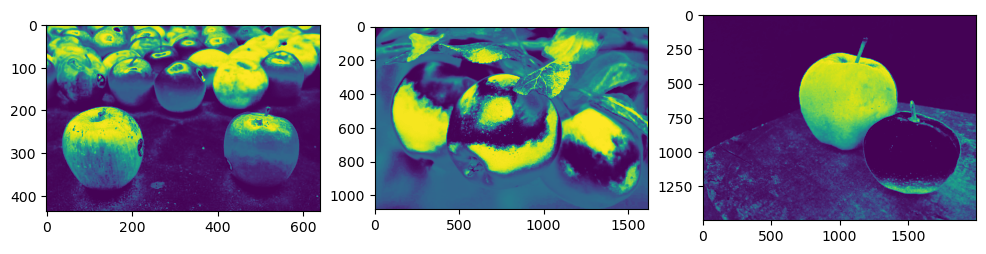

In [4]:
files_test = glob.glob("testApples/*.jpg")
num_files = len(files_test)
TestImgs = []

for myFile in files_test:
    im = plt.imread(myFile)
    imY, imX, imZ = im.shape
    posteriorApple = np.zeros([imY,imX])

    for cY in range(imY): 
        # print('Processing Row ',cY,'\n')
        for cX in range(imX):
            #extract this pixel's data
            thisPixelData = np.double(im[cY,cX,:])
            thisPixelData = thisPixelData.flatten()
            
            # calculate likelihood of this data given apple model
            likeApple = calcMixGaussianProb(thisPixelData,mixGaussEstApple)
            # calculate likelihood of this data given non apple model
            likeNonApple = calcMixGaussianProb(thisPixelData,mixGaussEstNonApple)
            # calculate posterior probability from likelihoods and priors using BAYES rule
            threshold = 0.5
            posteriorApple[cY, cX] = (likeApple * priorApple) / (likeApple * priorApple + likeNonApple * priorNonApple)


    posteriorApple = (posteriorApple * 255).astype(np.uint8)
    TestImgs.append(posteriorApple)

results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

fig = plt.figure(figsize=(12, 12))

# save the images
for i, img in enumerate(TestImgs):
    save_path = os.path.join(results_dir, f'posteriorApple_{i}.png')
    imageio.imsave(save_path, img)
    print(f'Saved: {save_path}')
    ax = plt.subplot(1, num_files, i + 1)
    plt.imshow(img)
    
plt.show()

Question D. Quantify and report the result by ploting the ROC curve.

In [6]:
im = plt.imread("testApples/TestApple.jpg")
file_ans = plt.imread("testApples/RealResult.png")
mask_img = cv2.cvtColor(file_ans, cv2.COLOR_RGB2GRAY)
mask_img = np.where(mask_img > 0.5, 1, 0)
imY, imX, imZ = im.shape
posteriorApple = np.zeros([imY,imX])

for cY in range(imY): 
    for cX in range(imX):
        thisPixelData = np.double(im[cY,cX,:])
        thisPixelData = thisPixelData.flatten()
        likeApple = calcMixGaussianProb(thisPixelData,mixGaussEstApple)
        likeNonApple = calcMixGaussianProb(thisPixelData,mixGaussEstNonApple)
        threshold = 0.5
        posteriorApple[cY, cX] = (likeApple * priorApple) / (likeApple * priorApple + likeNonApple * priorNonApple)


In [5]:
def calculate_roc_curve(posteriorApple, mask_img):
    thresholds = np.arange(0, 1.01, 0.01)  # Thresholds from 0 to 1
    ROC_data = []
    imY, imX = posteriorApple.shape

    # calculate TP, TN, FP, FN
    for thresh in thresholds:
        TP, TN, FP, FN = 0, 0, 0, 0
        for y in range(imY):
            for x in range(imX):
                if posteriorApple[y, x] > thresh:
                    if mask_img[y, x] == 1:
                        TP += 1
                    else:
                        FP += 1
                else:
                    if mask_img[y, x] == 0:
                        TN += 1
                    else:
                        FN += 1

        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # 1 - Specificity
        ROC_data.append((FPR, TPR))

    return ROC_data

def plot_roc_curve(ROC_data):
    # plot ROC curve
    FPR_values, TPR_values = zip(*ROC_data)
    plt.figure()
    plt.plot(FPR_values, TPR_values, color='blue', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random chance')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

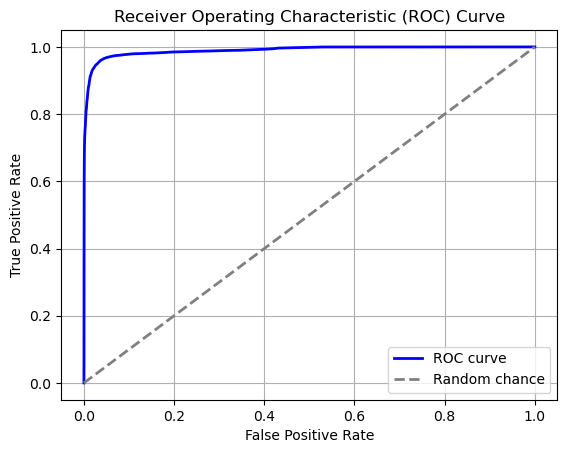

In [10]:
ROC_data = calculate_roc_curve(posteriorApple, mask_img)
plot_roc_curve(ROC_data)

Question E. Test images online as and quantify the result I get.  

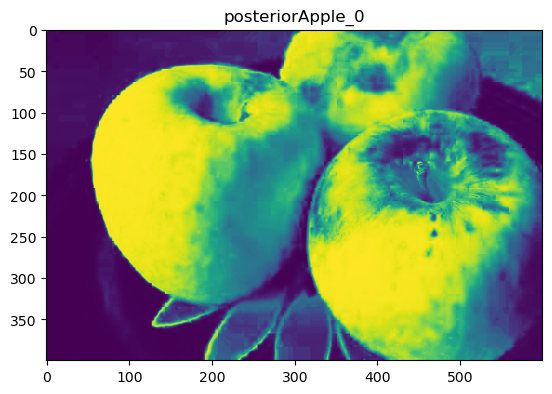

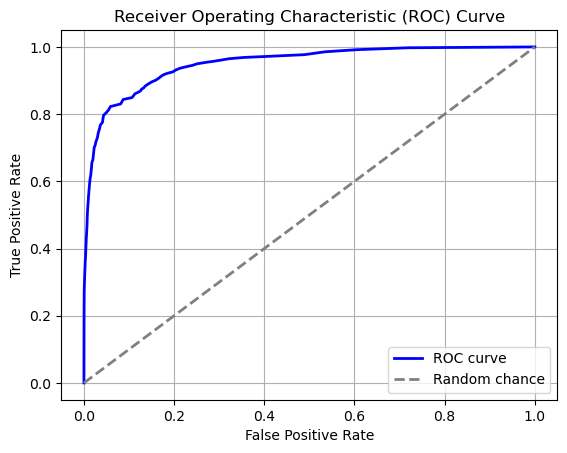

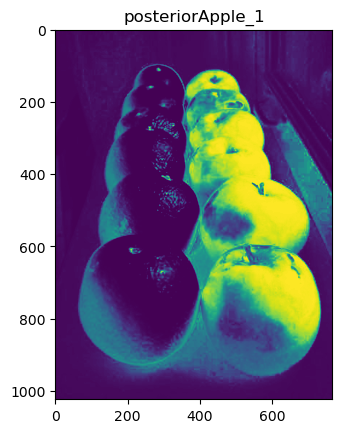

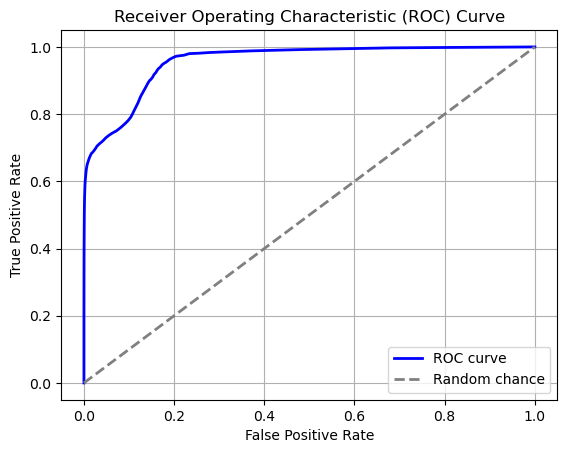

Saved: resultsOfOnlineApples\posteriorApple_0.png
Saved: resultsOfOnlineApples\posteriorApple_1.png


In [6]:
priorApple = 0.5
priorNonApple = 0.5
files_test = glob.glob("OnlineApples/*.jpg")
files_mask = glob.glob("OnlineApples/*.png")
TestImgs = []

for i, myFile in enumerate(files_test):
    im = plt.imread("OnlineApples/" + str(i) + ".jpg")
    file_ans = plt.imread("OnlineApples/mask" + str(i) + ".png")
    mask_img = cv2.cvtColor(file_ans, cv2.COLOR_RGB2GRAY)
    mask_img = np.where(mask_img > 0.5, 1, 0)
    imY, imX, imZ = im.shape
    posteriorApple = np.zeros([imY,imX])
    resultApple = np.zeros([imY,imX])

    for cY in range(imY): 
        # print('Processing Row ',cY,'\n')
        for cX in range(imX):
            #extract this pixel's data
            thisPixelData = np.double(im[cY,cX,:])
            thisPixelData = thisPixelData.flatten()   
            #calculate likelihood of this data given apple model
            likeApple = calcMixGaussianProb(thisPixelData,mixGaussEstApple)
            #calculate likelihood of this data given non apple model
            likeNonApple = calcMixGaussianProb(thisPixelData,mixGaussEstNonApple)
            # calculate posterior probability from likelihoods and priors using BAYES rule
            threshold = 0.5
            posteriorApple[cY, cX] = (likeApple * priorApple) / (likeApple * priorApple + likeNonApple * priorNonApple)
            if posteriorApple[cY, cX] > threshold:
                resultApple[cY, cX] = 1
            else:
                resultApple[cY, cX] = 0
    plt.title(f'posteriorApple_{i}')
    plt.imshow(posteriorApple)
    ROC_data = calculate_roc_curve(posteriorApple, mask_img)
    plot_roc_curve(ROC_data)
    resultApple = (resultApple * 255).astype(np.uint8)
    TestImgs.append(resultApple)

results_dir = 'resultsOfOnlineApples'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# save the images
for i, img in enumerate(TestImgs):
    save_path = os.path.join(results_dir, f'posteriorApple_{i}.png')
    imageio.imsave(save_path, img)
    print(f'Saved: {save_path}')

Question F. We should really be using three separate sets of files: a training set, a validation set, and a test set! Explain why：

In [ ]:
'''
A validation set is able to evaluate the model effect to tune the hyperparameters.
In this lab, I just assume the k of MixGaussian is 2 and the prior of Apple is 0.5.
However, this assumption may lead to very bad prediction cause it may be very inaccurate.
If we have a validation set, we can apply the mixGaussEst obtained from our training set along with the predicted prior probabilities to this validation 
 set to see if they can provide accurate results.
And we will be able to improve our hyperparameters by adjust them based on the result we get from our validation set.

'''